# This notebook merges data from OGLE II and III (from Bird+2012) with data from OGLE IV

In [1]:
import os
import fnmatch
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import lombscargle
import pandas as pd
import re
import glob
from IPython.display import clear_output


data_dir = "../data/"
list_from_bird_dir = "../data/ogle2_and_3/xrom_fixed/list.txt"

In [2]:
import psutil
psutil.Process().nice(5)# if on *ux

ModuleNotFoundError: No module named 'psutil'

# check coverage of the data 

In [ ]:
# # make a look up dictionary for source indices
# look_up_Bird = {}

# with open('../data/ogle2_and_3/xrom_fixed/lookup.txt') as f:
#     lines = f.readlines()
#     for line in lines:
#         look_up_Bird[int(line.split(" ")[0])] = line.split(" ")[1].replace("\n", "")

In [2]:
# load the list of SPX names from Bird+2012 and their corresponding IDs

with open(list_from_bird_dir) as f:
    lines = f.readlines()

ids_names = [re.split("\s+", line)[:3] for line in lines]
ids_names = [x[1:] if (x[0] == '') else x for x in ids_names]
ids_names = [x[:2] if len(x)>2 else x for x in ids_names]
ids_names = [x for x in ids_names if len(x)>1]
ids_names_bird = {int(sxp_id): sxp_name.lower() for sxp_id,sxp_name in ids_names}

In [3]:
# check the dates that the different data sets span for each source

# data_sets = ["ogle2_3/xrom_fixed/phot_I_calib/", "ogle3/", "ogle4/"]


ogle2_3_start_end = {}
ogle3_start_end = {}
ogle4_start_end = {}
maxima_2_3 = {}
maxima_3 = {}
minima_2_3 = {}
minima_3 = {}

for source_index, source_name in ids_names_bird.items():
    source_data = np.loadtxt('../data/ogle2_and_3/xrom_fixed/phot_I_calib/{}.dat'.format(source_index))
    ogle2_3_start_end[source_name] = (source_data[0,0], source_data[-1,0])
    try:
        maxima_2_3[source_name] = source_data[:,0][-740:][np.argmin(source_data[:,1])]
        minima_2_3[source_name] = source_data[:,0][-740:][np.argmax(source_data[:,1])]
    except:
        maxima_2_3[source_name] = source_data[:,0][np.argmin(source_data[:,1])]
        minima_2_3[source_name] = source_data[:,0][np.argmax(source_data[:,1])]

    
for source_index, source_name in ids_names_bird.items():
    try:
        source_data = np.loadtxt('../data/ogle3/{}/phot.dat'.format(source_name))
        ogle3_start_end[source_name] = (source_data[0,0]-2450000, source_data[-1,0]-2450000)
        maxima_3[source_name] = source_data[:,0][np.argmin(source_data[:,1])]-2450000
        minima_3[source_name] = source_data[:,0][np.argmax(source_data[:,1])]-2450000
    except:
        print("{} not found in OGLE3".format(source_name))
        ogle3_start_end[source_name] = (np.nan, np.nan)
        maxima_3[source_name] = np.nan
        minima_3[source_name] = np.nan

        
for source_index, source_name in ids_names_bird.items():
    try:
        source_data = np.loadtxt('../data/ogle4/{}/phot.dat'.format(source_name))
        ogle4_start_end[source_name] = (source_data[0,0]-2450000, source_data[-1,0]-2450000)
    except:
        print("{} not found in OGLE4".format(source_name))
        ogle4_start_end[source_name] = (np.nan, np.nan)

ogle_dates = pd.DataFrame({"Source":list(ids_names_bird.values()),
        "Bird2_3_start":[ogle2_3_start_end[x][0] for x in ids_names_bird.values()],
                           "Bird2_3_end":[ogle2_3_start_end[x][1] for x in ids_names_bird.values()], 
                           "ogle3_start":[ogle3_start_end[x][0] for x in ids_names_bird.values()], 
                           "ogle3_end":[ogle3_start_end[x][1] for x in ids_names_bird.values()],
                           
                           "Bird_ogle3_end_diff":[ogle3_start_end[x][1]-ogle2_3_start_end[x][1] for x in ids_names_bird.values()],
                           
                           "ogle4_start":[ogle4_start_end[x][0] for x in ids_names_bird.values()], 
                           "ogle4_end":[ogle4_start_end[x][1] for x in ids_names_bird.values()],
                          "maximum_Bird":[maxima_2_3[x] for x in ids_names_bird.values()],
                          "maximum3":[maxima_3[x] for x in ids_names_bird.values()],
                        "minimum_Bird":[minima_2_3[x] for x in ids_names_bird.values()],
                          "minimum3":[minima_3[x] for x in ids_names_bird.values()]},
                         index = np.array(range(len(ids_names_bird.values())))+1)

ogle_dates = ogle_dates[["Source","Bird2_3_start", "Bird2_3_end", "ogle3_start", "ogle3_end","Bird_ogle3_end_diff", "maximum_Bird", "maximum3","minimum_Bird", "minimum3", "ogle4_start", "ogle4_end"]]

sxp3.34 not found in OGLE3
sxp6.85 not found in OGLE3
sxp6.88 not found in OGLE3
sxp11.5 not found in OGLE3
sxp65.8 not found in OGLE3
sxp348 not found in OGLE3
rx-j0516.0-6916 not found in OGLE4
xmmu-j054134.7-682550 not found in OGLE4
rx-j0544.1-7100 not found in OGLE4
sxp2.763 not found in OGLE4
sxp18.3 not found in OGLE4
sxp31.0 not found in OGLE4
sxp152.1 not found in OGLE4
sxp202b not found in OGLE4
sxp264 not found in OGLE4
sxp455a not found in OGLE4
sxp455b not found in OGLE4
sxp893 not found in OGLE4
ma93-798 not found in OGLE4


In [4]:
start_short = []
finish_short = []

tolerance_days=0.01

for name, source in ogle_dates.iterrows():
    if source.Bird2_3_start-tolerance_days > source.ogle3_start:
        start_short.append(name)
        print(source.name, "Tony's data starts too late")
    if source.Bird2_3_end+tolerance_days < source.ogle3_end:
        finish_short.append(name)
        print(source.name, "Tony's data ends too early")

ogle_dates.style.apply(lambda x: ['background: lightgreen' 
                                  if (x.name in start_short)
                                  else 'background: yellow'
                                  if (x.name in finish_short)
                                  else '' for i in x], axis=1)

4 Tony's data starts too late
4 Tony's data ends too early
5 Tony's data starts too late
7 Tony's data ends too early
12 Tony's data ends too early
18 Tony's data ends too early
19 Tony's data ends too early
27 Tony's data ends too early
28 Tony's data ends too early
31 Tony's data ends too early
35 Tony's data ends too early
36 Tony's data ends too early
38 Tony's data ends too early
41 Tony's data ends too early
42 Tony's data ends too early
45 Tony's data ends too early
49 Tony's data ends too early
51 Tony's data ends too early
52 Tony's data ends too early
53 Tony's data ends too early


,Source,Bird2_3_start,Bird2_3_end,ogle3_start,ogle3_end,Bird_ogle3_end_diff,maximum_Bird,maximum3,minimum_Bird,minimum3,ogle4_start,ogle4_end
1,rx-j0513.9-6951,2167.845740,4951.524470,2167.845740,4951.524470,0.000000,2605.747710,2605.747710,2867.922340,4043.678920,5260.612080,8921.570890
2,rx-j0516.0-6916,457.650190,4953.516800,2112.931660,4953.516800,-0.000000,922.480210,3058.592950,4473.700830,3455.517850,nan,nan
3,rx-j0520.5-6932,455.674830,4953.516800,2112.931660,4953.516800,-0.000000,1329.500720,2135.924820,4394.716340,4394.716340,5260.612080,8921.570890
4,xmmu-j054134.7-682550,2187.300000,4947.030000,2168.853580,4947.531510,0.501510,3747.340000,4348.878190,2251.180000,2237.634110,nan,nan
5,cal-83,2187.795380,4947.531510,2168.853580,4947.531510,0.000000,3088.585570,3088.585570,4867.765860,4867.765860,5261.663600,8921.585690
6,rx-j0544.1-7100,2168.868010,4933.589370,2168.868010,4933.589370,0.000000,4378.784260,4378.784260,2335.522880,2335.522880,nan,nan
7,sxp0.92,625.430000,4866.050000,2090.906450,4866.552060,0.502060,667.385000,2222.629680,3633.180000,4080.599510,5346.921120,8869.575460
8,sxp2.37,2086.925270,4868.560230,2086.925270,4868.560230,-0.000000,4475.545300,4475.545300,2213.680140,2213.680140,5346.921120,8759.653130
9,sxp2.763,2086.932590,4868.567240,2086.932590,4868.567240,-0.000000,3020.598620,2850.921400,4120.575180,4120.575180,nan,nan
10,sxp7.78,2086.892120,4952.922020,2086.892120,4952.922020,-0.000000,2521.827000,2472.922920,3195.942100,3177.920920,5346.918930,8869.573160


# some of the sources in Bird+2012 data set seem to be off-set by -0.5 with respect to OGLE 3, but some do not 

# view the data for a few sources

sxp91.1


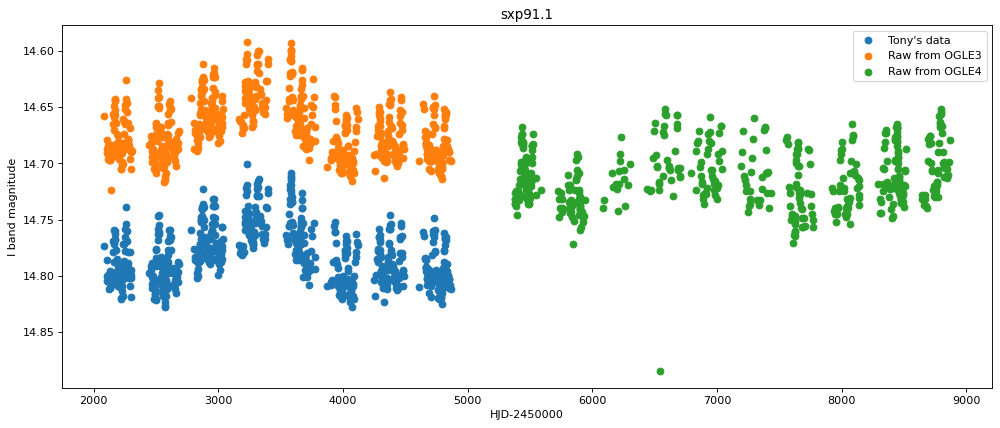

In [5]:
source_index = 23

lc_bird = np.loadtxt('../data/ogle2_and_3/xrom_fixed/phot_I_calib/{}.dat'.format(source_index))
lc_ogle3 = np.loadtxt('../data/ogle3/{}/phot.dat'.format(ids_names_bird[source_index]))
lc_ogle4 = np.loadtxt('../data/ogle4/{}/phot.dat'.format(ids_names_bird[source_index]))

print(ids_names_bird[source_index])
plt.figure(figsize=(15, 6), dpi=80)
plt.scatter(lc_bird[:,0], lc_bird[:,1], label="Tony's data")
plt.scatter(lc_ogle3[:,0]-2450000, lc_ogle3[:,1], label="Raw from OGLE3")
plt.scatter(lc_ogle4[:,0]-2450000, lc_ogle4[:,1], label="Raw from OGLE4")
plt.title(ids_names_bird[source_index])
plt.xlabel("HJD-2450000")
plt.ylabel("I band magnitude")
plt.gca().invert_yaxis()
plt.legend()
plt.show()

# in order to make sure that the data is properly aligned we need to take a look at light curves with flares and fold them on the right period
# load orbital period values

In [6]:
# load Mehtap's table of info for SMC objects with confirmed status
source_info = pd.read_csv("../data/SMC_confirmed.csv")

# data file names matching sources from Mehtap's table
ordered_file_names = [ 'sxp2.37.csv','','sxp3.34.csv','','sxp6.85.csv' ,'sxp7.78.csv', 'sxp8.80.csv', 'sxp9.13.csv','sxp11.5.csv', 'sxp15.3.csv',
                     '', 'sxp25.5.csv','sxp31.0.csv', 'sxp46.6.csv', 'sxp59.0.csv','sxp65.8.csv', 'sxp74.7.csv','sxp82.4.csv','sxp91.1.csv', 'sxp138.csv', 'sxp140.csv','',
                      '',  'sxp172.csv',  '','sxp214.csv','sxp264.csv', '', 'sxp293.csv', 'sxp323.csv','','sxp455.csv', 'sxp504.csv', 'sxp565.csv',
                      'sxp701.csv', 'sxp756.csv', 'sxp967.csv','sxp1062.csv', 'sxp1323.csv',]

bird_name = [x.replace(".csv", "") for x in ordered_file_names]


# build data frame with object name, orbital period and data file name
names_period = source_info[["Object", 'P_orb (d)','P_orb (d) II']]
names_period = names_period.join(pd.DataFrame({"file": ordered_file_names}))
names_period = names_period.join(pd.DataFrame({"Bird_name": bird_name}))

In [7]:
from fbprophet import Prophet

Importing plotly failed. Interactive plots will not work.


Initial log joint probability = -2.64089
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4408.45     0.0206167       1128.86           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        4432.2    0.00452486       779.649       0.414           1      246   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       4434.19   8.69865e-05       107.877      0.4043      0.4043      369   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     327       4434.42   2.82447e-05       160.744   5.115e-08       0.001      455  LS failed, Hessian reset 
     383       4434.86   9.93847e-06       104.836   7.214e-08       0.001      568  LS failed, Hessian reset 
     399       4434.87     2.518e-05       94.0006      0.2475           1      590   
    Iter      log pro

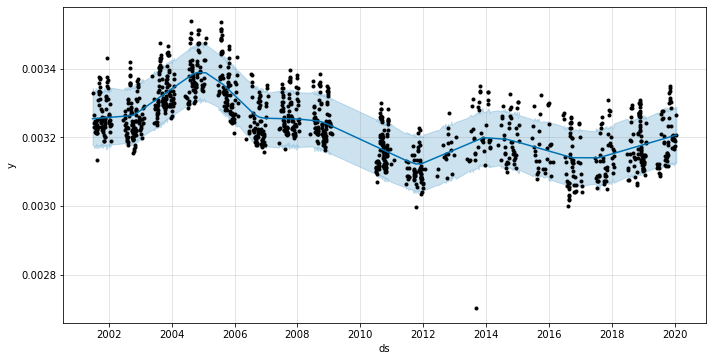

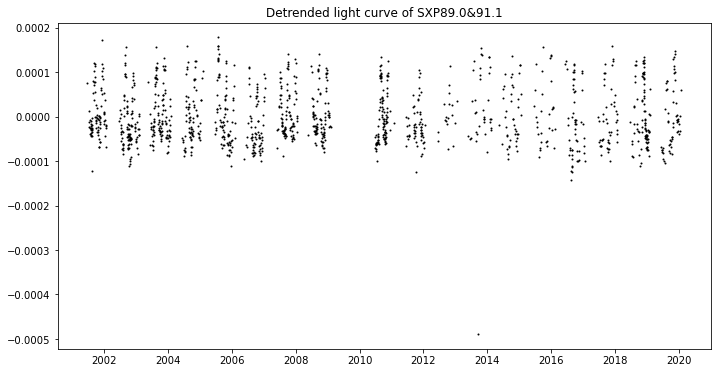

Initial log joint probability = -61.2953
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1076.13     0.0145299       124.386           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     135       1076.83    0.00023893       110.736   1.971e-06       0.001      188  LS failed, Hessian reset 
     199       1076.85    3.0726e-06       112.713           1           1      266   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     278       1076.85   1.11453e-06       115.683   9.769e-09       0.001      402  LS failed, Hessian reset 
     296       1076.85   3.19355e-08       102.721      0.2519           1      424   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


<Figure size 720x360 with 0 Axes>

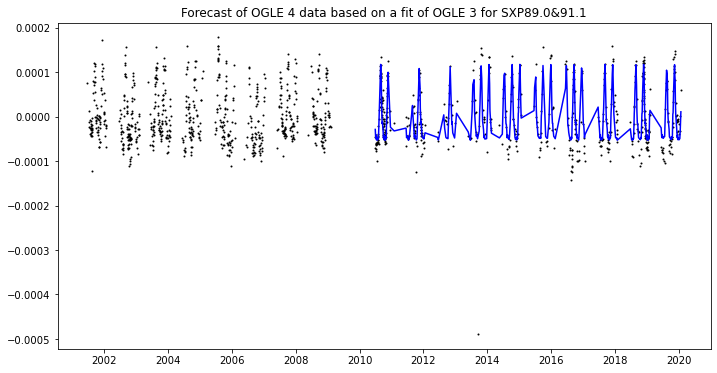

In [8]:
plt.rcParams['figure.figsize'] = (11.7, 6.0)
source = names_period.iloc[18,:]

data_path = "../data/"



data = np.loadtxt(data_path+"ogle_merged/"+source["file"], delimiter=",", dtype=float)#
#     plt.plot([2455081.5,2455081.5], np.array([np.min(data[:,1]), np.max(data[:,1])])*-1, color="r")
data_df = pd.DataFrame({"ds": data[:,0],"y": data[:,1]})
data_df["ds"] = pd.to_datetime(data_df["ds"], origin="julian", unit="D")
data_df["y"] = float(2430)*10**(-1.0*data_df["y"]/2.5)
m = Prophet(
    growth='linear',
    changepoints=None,
    n_changepoints=50,
    changepoint_range=0.99,
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
    holidays=None,
    seasonality_mode='additive',
    seasonality_prior_scale=10.0,
    holidays_prior_scale=10.0,
    changepoint_prior_scale=0.05,
    mcmc_samples=0,
    interval_width=0.8,
    uncertainty_samples=1000,
    stan_backend=None,
)
m.fit(data_df)
forecast = m.predict(pd.DataFrame(data_df["ds"]))
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

# plot data with prophet model
print("Source: {}".format(source["Object"]) + " prophet model" + " Period: {}".format(source["P_orb (d)"]))
fig1 = m.plot(forecast)
fig = plt.gcf()
fig.set_size_inches(10,5)
plt.show()
# plot data with trend subtracted
detrended = data_df.copy(deep=True)
detrended["y"] = data_df["y"].values-forecast['trend'].values
plt.scatter(detrended["ds"].values,detrended["y"], s=1, c="black")
plt.title("Detrended light curve of {}".format(source["Object"]))
plt.show()


# now fit a model to detrended OGLE 3

# fit prophet model with orbital periodicity component
m = Prophet(
    growth='linear',
    changepoints=None,
    n_changepoints=50,
    changepoint_range=0.99,
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
    holidays=None,
    seasonality_mode='additive',
    seasonality_prior_scale=10.0,
    holidays_prior_scale=10.0,
    changepoint_prior_scale=0.05,
    mcmc_samples=0,
    interval_width=0.8,
    uncertainty_samples=1000,
    stan_backend=None,
) #"07-09-2009"
m.add_seasonality(name='orbital', period=source["P_orb (d)"], fourier_order=15)
m.fit(detrended.iloc[:729])

forecast = m.predict(pd.DataFrame(detrended.iloc[729:]["ds"]))

fig = plt.gcf()
fig.set_size_inches(10,5)
plt.show()

plt.scatter(detrended["ds"].values,detrended["y"], s=1, c="black")
plt.plot(forecast["ds"].values,forecast["yhat"]-forecast["trend"], c="blue")

plt.title("Forecast of OGLE 4 data based on a fit of OGLE 3 for {}".format(source["Object"]))
plt.show()


In [109]:
plt.rcParams['figure.figsize'] = (11.7, 6.0)
source = names_period.iloc[18,:]

data_path = "../data/"


data = np.loadtxt(data_path+"ogle_merged/"+source["file"], delimiter=",", dtype=float)#
#     plt.plot([2455081.5,2455081.5], np.array([np.min(data[:,1]), np.max(data[:,1])])*-1, color="r")
data_df = pd.DataFrame({"ds": data[:,0],"y": data[:,1]})
data_df["ds"] = pd.to_datetime(data_df["ds"], origin="julian", unit="D")
data_df["y"] = float(2430)*10**(-1.0*data_df["y"]/2.5)
m = Prophet(
    growth='linear',
    changepoints=None,
    n_changepoints=50,
    changepoint_range=0.99,
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
    holidays=None,
    seasonality_mode='additive',
    seasonality_prior_scale=10.0,
    holidays_prior_scale=10.0,
    changepoint_prior_scale=0.05,
    mcmc_samples=0,
    interval_width=0.8,
    uncertainty_samples=1000,
    stan_backend=None,
)
m.fit(data_df)
forecast = m.predict(pd.DataFrame(data_df["ds"]))
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

detrended = data_df.copy(deep=True)
detrended["y"] = data_df["y"].values-forecast['trend'].values


# now fit a model to detrended OGLE 3

# fit prophet model with orbital periodicity component
m = Prophet(
    growth='linear',
    changepoints=None,
    n_changepoints=50,
    changepoint_range=0.99,
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
    holidays=None,
    seasonality_mode='additive',
    seasonality_prior_scale=10.0,
    holidays_prior_scale=10.0,
    changepoint_prior_scale=0.05,
    mcmc_samples=0,
    interval_width=0.8,
    uncertainty_samples=1000,
    stan_backend=None,
) #"07-09-2009"
m.add_seasonality(name='orbital', period=source["P_orb (d)"], fourier_order=15)
m.fit(detrended.iloc[:729])

forecast = m.predict(pd.DataFrame(detrended.iloc[729:]["ds"]))




results = []

for offset in np.arange(-3,3,0.1):
    print(len(results))
    
    
    forecast = m.predict(pd.DataFrame(detrended.iloc[729:]["ds"]+pd.to_timedelta(offset, unit="D")))
    
    results.append((offset, np.sqrt(np.mean(((forecast["yhat"]-forecast["trend"]).values-detrended.iloc[729:]["y"].values)**2))))
    clear_output(wait=True)


59


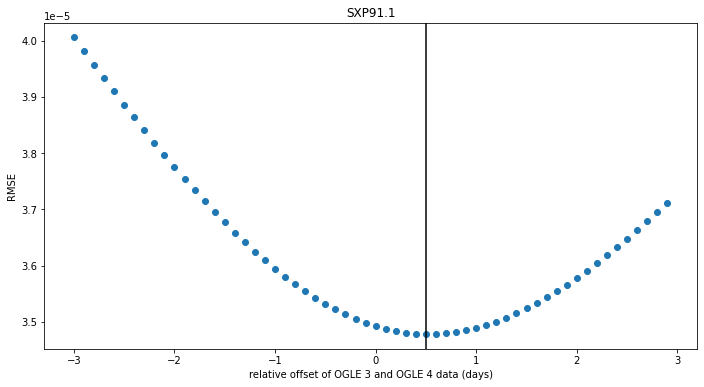

In [123]:
plt.scatter(np.array(results)[:,0],np.array(results)[:,1])
plt.axvline(np.array(results)[:,0][np.argmin(np.array(results)[:,1])], c="black")
plt.xlabel("relative offset of OGLE 3 and OGLE 4 data (days)")
plt.ylabel("RMSE")
plt.title("SXP91.1")
plt.show()

Initial log joint probability = -7.00606
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3960.37    0.00156576       949.044      0.5187      0.5187      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       4145.19     0.0140425       533.402           1           1      249   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       4213.86    0.00168337       474.701           1           1      377   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       4240.96    0.00147852       786.461           1           1      498   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       4249.96   0.000963245       724.714      0.5084      0.5084      621   
    Iter      log prob        ||dx||      ||grad||       alpha  

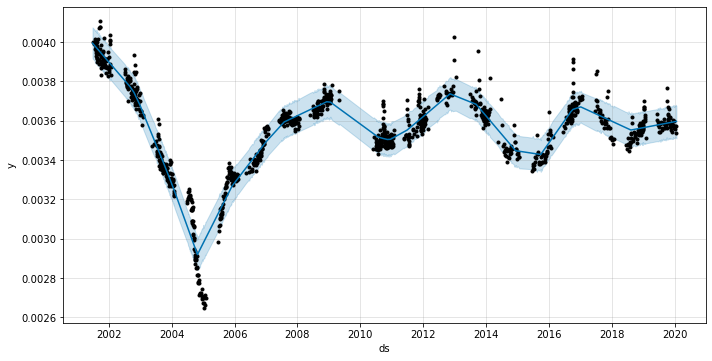

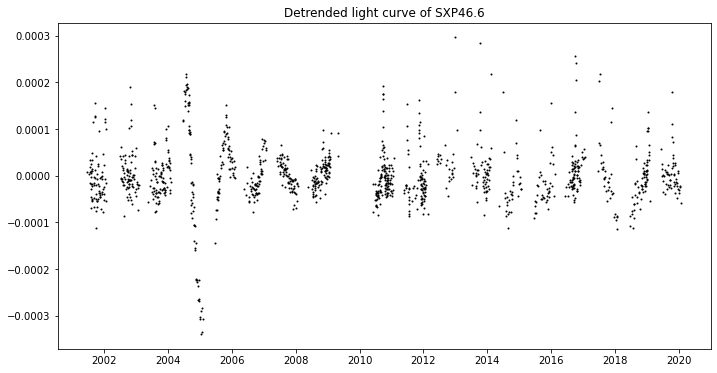

Initial log joint probability = -23.6597
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       690.983   6.22831e-05       110.389      0.5736      0.5736      112   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       691.006   2.96727e-06       128.644           1           1      229   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     229       691.007   5.48509e-09       117.921      0.2311      0.8617      265   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


<Figure size 720x360 with 0 Axes>

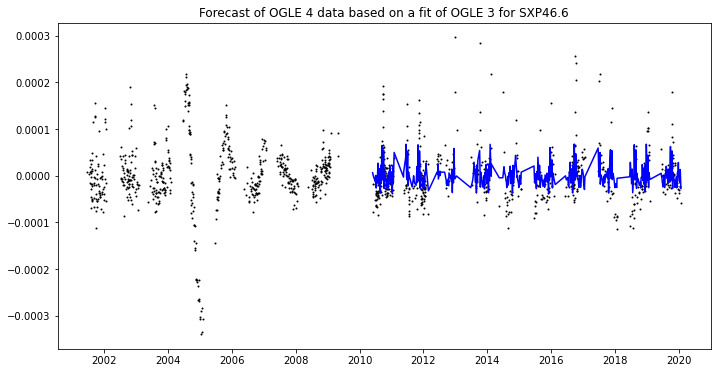

In [142]:
plt.rcParams['figure.figsize'] = (11.7, 6.0)
source = names_period.iloc[13,:]

data_path = "../data/"



data = np.loadtxt(data_path+"ogle_merged/"+source["file"], delimiter=",", dtype=float)#
#     plt.plot([2455081.5,2455081.5], np.array([np.min(data[:,1]), np.max(data[:,1])])*-1, color="r")
data_df = pd.DataFrame({"ds": data[:,0],"y": data[:,1]})
data_df["ds"] = pd.to_datetime(data_df["ds"], origin="julian", unit="D")
data_df["y"] = float(2430)*10**(-1.0*data_df["y"]/2.5)

ogle3_end = np.sum(data_df["ds"]<"2010-01-01")

m = Prophet(
    growth='linear',
    changepoints=None,
    n_changepoints=50,
    changepoint_range=0.99,
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
    holidays=None,
    seasonality_mode='additive',
    seasonality_prior_scale=10.0,
    holidays_prior_scale=10.0,
    changepoint_prior_scale=0.05,
    mcmc_samples=0,
    interval_width=0.8,
    uncertainty_samples=1000,
    stan_backend=None,
)
m.fit(data_df)
forecast = m.predict(pd.DataFrame(data_df["ds"]))
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

# plot data with prophet model
print("Source: {}".format(source["Object"]) + " prophet model" + " Period: {}".format(source["P_orb (d)"]))
fig1 = m.plot(forecast)
fig = plt.gcf()
fig.set_size_inches(10,5)
plt.show()
# plot data with trend subtracted
detrended = data_df.copy(deep=True)
detrended["y"] = data_df["y"].values-forecast['trend'].values
plt.scatter(detrended["ds"].values,detrended["y"], s=1, c="black")
plt.title("Detrended light curve of {}".format(source["Object"]))
plt.show()


# now fit a model to detrended OGLE 3

# fit prophet model with orbital periodicity component
m = Prophet(
    growth='linear',
    changepoints=None,
    n_changepoints=50,
    changepoint_range=0.99,
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
    holidays=None,
    seasonality_mode='additive',
    seasonality_prior_scale=10.0,
    holidays_prior_scale=10.0,
    changepoint_prior_scale=0.05,
    mcmc_samples=0,
    interval_width=0.8,
    uncertainty_samples=1000,
    stan_backend=None,
) #"07-09-2009"
m.add_seasonality(name='orbital', period=source["P_orb (d)"], fourier_order=15)
m.fit(detrended.iloc[:ogle3_end])

forecast = m.predict(pd.DataFrame(detrended.iloc[ogle3_end:]["ds"]))

fig = plt.gcf()
fig.set_size_inches(10,5)
plt.show()

plt.scatter(detrended["ds"].values,detrended["y"], s=1, c="black")
plt.plot(forecast["ds"].values,forecast["yhat"]-forecast["trend"], c="blue")

plt.title("Forecast of OGLE 4 data based on a fit of OGLE 3 for {}".format(source["Object"]))
plt.show()


In [146]:
plt.rcParams['figure.figsize'] = (11.7, 6.0)
source = names_period.iloc[13,:]

data_path = "../data/"


data = np.loadtxt(data_path+"ogle_merged/"+source["file"], delimiter=",", dtype=float)#
#     plt.plot([2455081.5,2455081.5], np.array([np.min(data[:,1]), np.max(data[:,1])])*-1, color="r")
data_df = pd.DataFrame({"ds": data[:,0],"y": data[:,1]})
data_df["ds"] = pd.to_datetime(data_df["ds"], origin="julian", unit="D")
data_df["y"] = float(2430)*10**(-1.0*data_df["y"]/2.5)
ogle3_end = np.sum(data_df["ds"]<"2010-01-01")

m = Prophet(
    growth='linear',
    changepoints=None,
    n_changepoints=50,
    changepoint_range=0.99,
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
    holidays=None,
    seasonality_mode='additive',
    seasonality_prior_scale=10.0,
    holidays_prior_scale=10.0,
    changepoint_prior_scale=0.05,
    mcmc_samples=0,
    interval_width=0.8,
    uncertainty_samples=1000,
    stan_backend=None,
)
m.fit(data_df)
forecast = m.predict(pd.DataFrame(data_df["ds"]))
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

detrended = data_df.copy(deep=True)
detrended["y"] = data_df["y"].values-forecast['trend'].values


# now fit a model to detrended OGLE 3

# fit prophet model with orbital periodicity component
m = Prophet(
    growth='linear',
    changepoints=None,
    n_changepoints=50,
    changepoint_range=0.99,
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
    holidays=None,
    seasonality_mode='additive',
    seasonality_prior_scale=10.0,
    holidays_prior_scale=10.0,
    changepoint_prior_scale=0.05,
    mcmc_samples=0,
    interval_width=0.8,
    uncertainty_samples=1000,
    stan_backend=None,
) #"07-09-2009"
m.add_seasonality(name='orbital', period=source["P_orb (d)"], fourier_order=15)
m.fit(detrended.iloc[:ogle3_end])

forecast = m.predict(pd.DataFrame(detrended.iloc[ogle3_end:]["ds"]))




results = []

for offset in np.arange(-3,3,0.1):
    print(len(results))
    
    
    forecast = m.predict(pd.DataFrame(detrended.iloc[ogle3_end:]["ds"]+pd.to_timedelta(offset, unit="D")))
    
    results.append((offset, np.sqrt(np.mean(((forecast["yhat"]-forecast["trend"]).values-detrended.iloc[ogle3_end:]["y"].values)**2))))
    clear_output(wait=True)


59


In [148]:
source

Object              SXP46.6
P_orb (d)            137.36
P_orb (d) II       (143.29)
file            sxp46.6.csv
Bird_name           sxp46.6
Name: 13, dtype: object

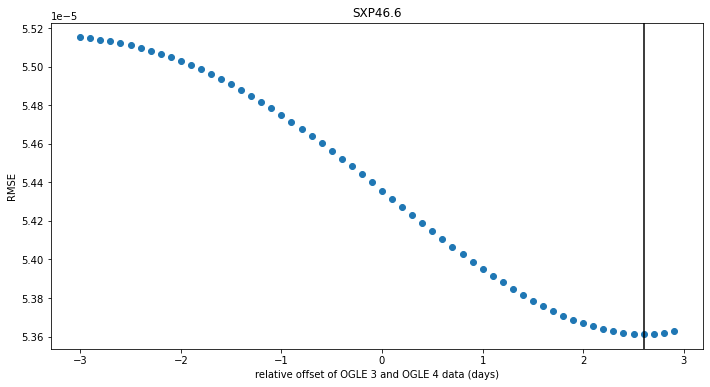

In [149]:
plt.scatter(np.array(results)[:,0],np.array(results)[:,1])
plt.axvline(np.array(results)[:,0][np.argmin(np.array(results)[:,1])], c="black")
plt.xlabel("relative offset of OGLE 3 and OGLE 4 data (days)")
plt.ylabel("RMSE")
plt.title(source["Object"])
plt.show()

Initial log joint probability = -4.00746
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3589.09    0.00256861       126.087      0.1434           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     155       3592.31   0.000139849       131.924   3.569e-07       0.001      236  LS failed, Hessian reset 
     199       3593.75   0.000106571       130.292           1           1      285   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3597.84      0.016542       278.493           1           1      408   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3602.61    0.00412092       464.424           1           1      531   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        3604.7   4.22019e-05    

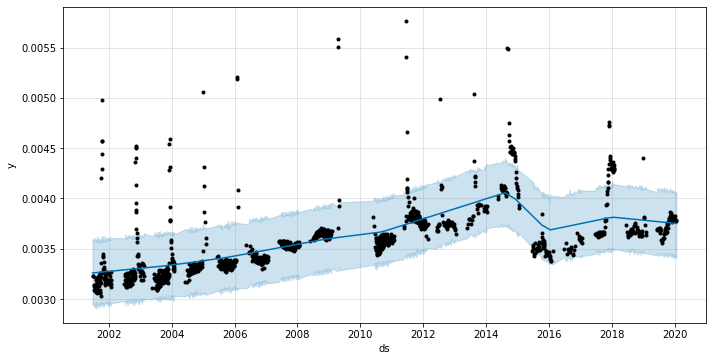

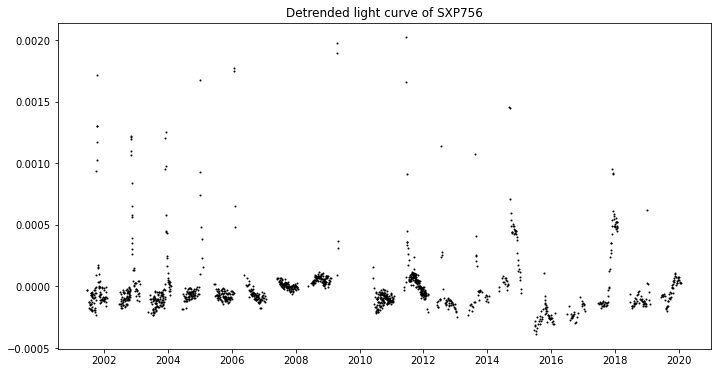

Initial log joint probability = -11.5466
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1668.52   0.000960493       129.708      0.9997      0.9997      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     154       1668.88   3.03438e-05       135.238    2.46e-07       0.001      214  LS failed, Hessian reset 
     199       1668.88   6.88362e-06       122.185           1           1      266   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     216       1668.89   5.67068e-05       126.651   4.232e-07       0.001      330  LS failed, Hessian reset 
     249       1668.89   4.30466e-08       109.078      0.3109           1      370   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


<Figure size 720x360 with 0 Axes>

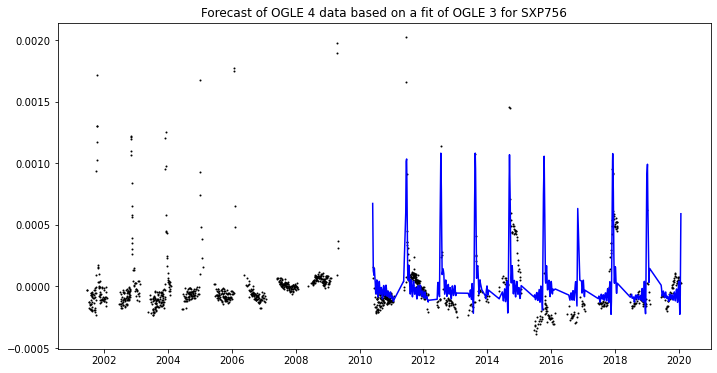

In [155]:
plt.rcParams['figure.figsize'] = (11.7, 6.0)
source = names_period.iloc[35,:]

data_path = "../data/"



data = np.loadtxt(data_path+"ogle_merged/"+source["file"], delimiter=",", dtype=float)#
#     plt.plot([2455081.5,2455081.5], np.array([np.min(data[:,1]), np.max(data[:,1])])*-1, color="r")
data_df = pd.DataFrame({"ds": data[:,0],"y": data[:,1]})
data_df["ds"] = pd.to_datetime(data_df["ds"], origin="julian", unit="D")
data_df["y"] = float(2430)*10**(-1.0*data_df["y"]/2.5)

ogle3_end = np.sum(data_df["ds"]<"2010-01-01")

m = Prophet(
    growth='linear',
    changepoints=None,
    n_changepoints=50,
    changepoint_range=0.99,
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
    holidays=None,
    seasonality_mode='additive',
    seasonality_prior_scale=10.0,
    holidays_prior_scale=10.0,
    changepoint_prior_scale=0.05,
    mcmc_samples=0,
    interval_width=0.8,
    uncertainty_samples=1000,
    stan_backend=None,
)
m.fit(data_df)
forecast = m.predict(pd.DataFrame(data_df["ds"]))
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

# plot data with prophet model
print("Source: {}".format(source["Object"]) + " prophet model" + " Period: {}".format(source["P_orb (d)"]))
fig1 = m.plot(forecast)
fig = plt.gcf()
fig.set_size_inches(10,5)
plt.show()
# plot data with trend subtracted
detrended = data_df.copy(deep=True)
detrended["y"] = data_df["y"].values-forecast['trend'].values
plt.scatter(detrended["ds"].values,detrended["y"], s=1, c="black")
plt.title("Detrended light curve of {}".format(source["Object"]))
plt.show()


# now fit a model to detrended OGLE 3

# fit prophet model with orbital periodicity component
m = Prophet(
    growth='linear',
    changepoints=None,
    n_changepoints=50,
    changepoint_range=0.99,
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
    holidays=None,
    seasonality_mode='additive',
    seasonality_prior_scale=10.0,
    holidays_prior_scale=10.0,
    changepoint_prior_scale=0.05,
    mcmc_samples=0,
    interval_width=0.8,
    uncertainty_samples=1000,
    stan_backend=None,
) #"07-09-2009"
m.add_seasonality(name='orbital', period=source["P_orb (d)"], fourier_order=15)
m.fit(detrended.iloc[:ogle3_end])

forecast = m.predict(pd.DataFrame(detrended.iloc[ogle3_end:]["ds"]))

fig = plt.gcf()
fig.set_size_inches(10,5)
plt.show()

plt.scatter(detrended["ds"].values,detrended["y"], s=1, c="black")
plt.plot(forecast["ds"].values,forecast["yhat"]-forecast["trend"], c="blue")

plt.title("Forecast of OGLE 4 data based on a fit of OGLE 3 for {}".format(source["Object"]))
plt.show()


In [156]:
plt.rcParams['figure.figsize'] = (11.7, 6.0)
source = names_period.iloc[35,:]

data_path = "../data/"


data = np.loadtxt(data_path+"ogle_merged/"+source["file"], delimiter=",", dtype=float)#
#     plt.plot([2455081.5,2455081.5], np.array([np.min(data[:,1]), np.max(data[:,1])])*-1, color="r")
data_df = pd.DataFrame({"ds": data[:,0],"y": data[:,1]})
data_df["ds"] = pd.to_datetime(data_df["ds"], origin="julian", unit="D")
data_df["y"] = float(2430)*10**(-1.0*data_df["y"]/2.5)
ogle3_end = np.sum(data_df["ds"]<"2010-01-01")

m = Prophet(
    growth='linear',
    changepoints=None,
    n_changepoints=50,
    changepoint_range=0.99,
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
    holidays=None,
    seasonality_mode='additive',
    seasonality_prior_scale=10.0,
    holidays_prior_scale=10.0,
    changepoint_prior_scale=0.05,
    mcmc_samples=0,
    interval_width=0.8,
    uncertainty_samples=1000,
    stan_backend=None,
)
m.fit(data_df)
forecast = m.predict(pd.DataFrame(data_df["ds"]))
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

detrended = data_df.copy(deep=True)
detrended["y"] = data_df["y"].values-forecast['trend'].values


# now fit a model to detrended OGLE 3

# fit prophet model with orbital periodicity component
m = Prophet(
    growth='linear',
    changepoints=None,
    n_changepoints=50,
    changepoint_range=0.99,
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
    holidays=None,
    seasonality_mode='additive',
    seasonality_prior_scale=10.0,
    holidays_prior_scale=10.0,
    changepoint_prior_scale=0.05,
    mcmc_samples=0,
    interval_width=0.8,
    uncertainty_samples=1000,
    stan_backend=None,
) #"07-09-2009"
m.add_seasonality(name='orbital', period=source["P_orb (d)"], fourier_order=15)
m.fit(detrended.iloc[:ogle3_end])

forecast = m.predict(pd.DataFrame(detrended.iloc[ogle3_end:]["ds"]))




results = []

for offset in np.arange(-3,3,0.1):
    print(len(results))
    
    
    forecast = m.predict(pd.DataFrame(detrended.iloc[ogle3_end:]["ds"]+pd.to_timedelta(offset, unit="D")))
    
    results.append((offset, np.sqrt(np.mean(((forecast["yhat"]-forecast["trend"]).values-detrended.iloc[ogle3_end:]["y"].values)**2))))
    clear_output(wait=True)


59


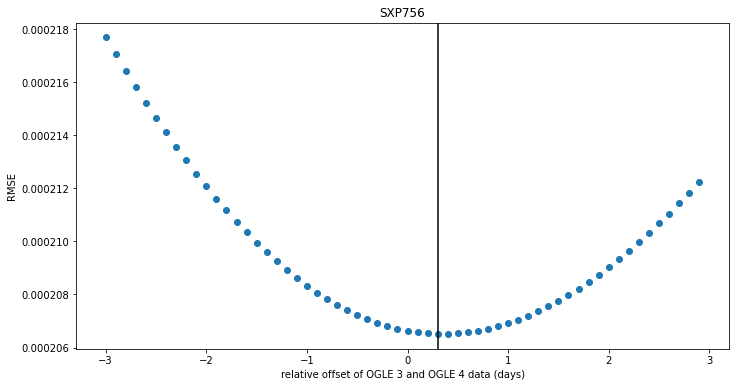

In [158]:
plt.scatter(np.array(results)[:,0],np.array(results)[:,1])
plt.axvline(np.array(results)[:,0][np.argmin(np.array(results)[:,1])], c="black")
plt.xlabel("relative offset of OGLE 3 and OGLE 4 data (days)")
plt.ylabel("RMSE")
plt.title(source["Object"])
plt.show()

Initial log joint probability = -12.5178
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3105.22    0.00567064       427.498     0.05247           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3117.15   0.000883742       110.245      0.6837      0.6837      261   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     267        3120.1   0.000282179       185.878   2.721e-06       0.001      387  LS failed, Hessian reset 
     299       3121.16   0.000415822       103.176           1           1      429   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     333       3122.07   0.000448867       235.343   4.298e-06       0.001      521  LS failed, Hessian reset 
     399       3123.11   0.000584739         99.99      0.9189      0.9189      597   
    Iter      log pro

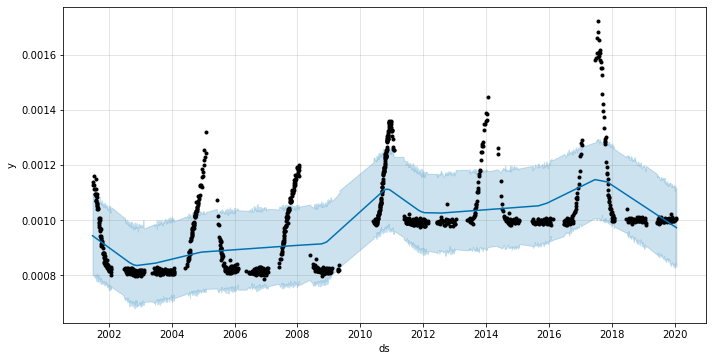

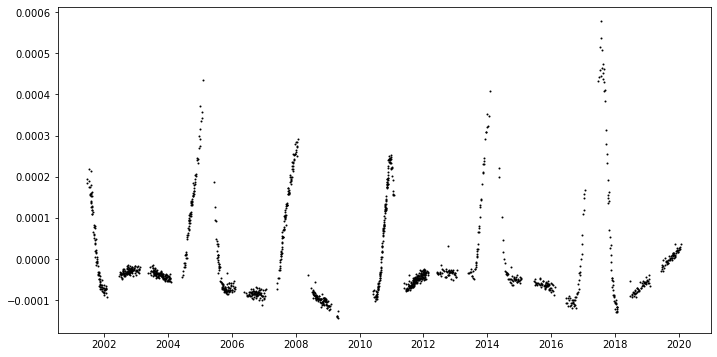

Initial log joint probability = -41.8733
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       724.545   0.000123885       106.059      0.3782           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       726.733    0.00115724        89.244      0.6346      0.6346      233   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     213       727.163    0.00170671       126.107   1.522e-05       0.001      292  LS failed, Hessian reset 
     299       727.416   1.48616e-06       96.7232      0.5672      0.5672      397   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       727.476   3.82657e-05       72.6976           1           1      520   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     469       727.497   8.73809e-09    

<Figure size 720x360 with 0 Axes>

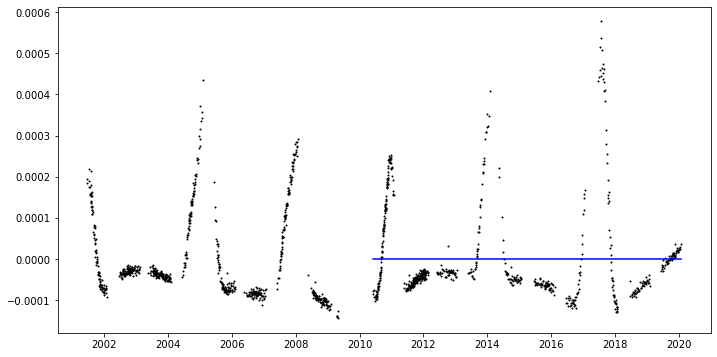

In [13]:
plt.rcParams['figure.figsize'] = (11.7, 6.0)
# source = names_period.iloc[35,:]

data_path = "../data/"



data = np.loadtxt(data_path+"ogle_merged/"+"rx-j0052.1-7319.csv", delimiter=",", dtype=float)#
#     plt.plot([2455081.5,2455081.5], np.array([np.min(data[:,1]), np.max(data[:,1])])*-1, color="r")
data_df = pd.DataFrame({"ds": data[:,0],"y": data[:,1]})
data_df["ds"] = pd.to_datetime(data_df["ds"], origin="julian", unit="D")
data_df["y"] = float(2430)*10**(-1.0*data_df["y"]/2.5)

ogle3_end = np.sum(data_df["ds"]<"2010-01-01")

m = Prophet(
    growth='linear',
    changepoints=None,
    n_changepoints=50,
    changepoint_range=0.99,
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
    holidays=None,
    seasonality_mode='additive',
    seasonality_prior_scale=10.0,
    holidays_prior_scale=10.0,
    changepoint_prior_scale=0.05,
    mcmc_samples=0,
    interval_width=0.8,
    uncertainty_samples=1000,
    stan_backend=None,
)
m.fit(data_df)
forecast = m.predict(pd.DataFrame(data_df["ds"]))
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

# plot data with prophet model
# print("Source: {}".format(source["Object"]) + " prophet model" + " Period: {}".format(source["P_orb (d)"]))
fig1 = m.plot(forecast)
fig = plt.gcf()
fig.set_size_inches(10,5)
plt.show()
# plot data with trend subtracted
detrended = data_df.copy(deep=True)
detrended["y"] = data_df["y"].values-forecast['trend'].values
plt.scatter(detrended["ds"].values,detrended["y"], s=1, c="black")
# plt.title("Detrended light curve of {}".format(source["Object"]))
plt.show()


# now fit a model to detrended OGLE 3

# fit prophet model with orbital periodicity component
m = Prophet(
    growth='linear',
    changepoints=None,
    n_changepoints=50,
    changepoint_range=0.99,
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
    holidays=None,
    seasonality_mode='additive',
    seasonality_prior_scale=10.0,
    holidays_prior_scale=10.0,
    changepoint_prior_scale=0.05,
    mcmc_samples=0,
    interval_width=0.8,
    uncertainty_samples=1000,
    stan_backend=None,
) #"07-09-2009"
# m.add_seasonality(name='orbital', period=source["P_orb (d)"], fourier_order=15)
m.fit(detrended.iloc[:ogle3_end])

forecast = m.predict(pd.DataFrame(detrended.iloc[ogle3_end:]["ds"]))

fig = plt.gcf()
fig.set_size_inches(10,5)
plt.show()

plt.scatter(detrended["ds"].values,detrended["y"], s=1, c="black")
plt.plot(forecast["ds"].values,forecast["yhat"]-forecast["trend"], c="blue")

# plt.title("Forecast of OGLE 4 data based on a fit of OGLE 3 for {}".format(source["Object"]))
plt.show()


In [17]:
detrended.iloc[:ogle3_end]

,ds,y
0,2001-06-25 09:49:09.696010368,0.000195
1,2001-06-26 09:19:20.351984256,0.000186
2,2001-07-13 09:29:09.600005120,0.000219
3,2001-07-15 10:09:20.160014080,0.000175
4,2001-07-16 09:23:00.672012288,0.000190
...,...,...
742,2009-04-15 09:59:49.920017152,-0.000141
743,2009-04-19 09:34:53.472008448,-0.000139
744,2009-04-19 09:40:26.976013056,-0.000138
745,2009-05-02 09:31:35.615990528,-0.000125


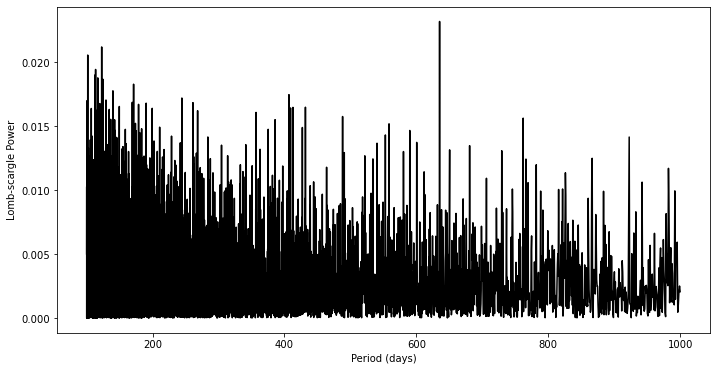

In [24]:
from scipy.signal import lombscargle

f = np.linspace(1/1000, 1/100, 10000)*2*np.pi


pgram = lombscargle(detrended.iloc[:ogle3_end]["ds"].values, detrended.iloc[:ogle3_end]["y"].values, f, normalize=True) # angular frequencies
plt.plot(1/(f/(2*np.pi)), pgram, zorder=2, c="black") # per day frequencies
plt.xlabel('Period (days)')
plt.ylabel('Lomb-scargle Power')
plt.show()

In [156]:
plt.rcParams['figure.figsize'] = (11.7, 6.0)
source = names_period.iloc[35,:]

data_path = "../data/"


data = np.loadtxt(data_path+"ogle_merged/"+source["file"], delimiter=",", dtype=float)#
#     plt.plot([2455081.5,2455081.5], np.array([np.min(data[:,1]), np.max(data[:,1])])*-1, color="r")
data_df = pd.DataFrame({"ds": data[:,0],"y": data[:,1]})
data_df["ds"] = pd.to_datetime(data_df["ds"], origin="julian", unit="D")
data_df["y"] = float(2430)*10**(-1.0*data_df["y"]/2.5)
ogle3_end = np.sum(data_df["ds"]<"2010-01-01")

m = Prophet(
    growth='linear',
    changepoints=None,
    n_changepoints=50,
    changepoint_range=0.99,
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
    holidays=None,
    seasonality_mode='additive',
    seasonality_prior_scale=10.0,
    holidays_prior_scale=10.0,
    changepoint_prior_scale=0.05,
    mcmc_samples=0,
    interval_width=0.8,
    uncertainty_samples=1000,
    stan_backend=None,
)
m.fit(data_df)
forecast = m.predict(pd.DataFrame(data_df["ds"]))
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

detrended = data_df.copy(deep=True)
detrended["y"] = data_df["y"].values-forecast['trend'].values


# now fit a model to detrended OGLE 3

# fit prophet model with orbital periodicity component
m = Prophet(
    growth='linear',
    changepoints=None,
    n_changepoints=50,
    changepoint_range=0.99,
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
    holidays=None,
    seasonality_mode='additive',
    seasonality_prior_scale=10.0,
    holidays_prior_scale=10.0,
    changepoint_prior_scale=0.05,
    mcmc_samples=0,
    interval_width=0.8,
    uncertainty_samples=1000,
    stan_backend=None,
) #"07-09-2009"
m.add_seasonality(name='orbital', period=source["P_orb (d)"], fourier_order=15)
m.fit(detrended.iloc[:ogle3_end])

forecast = m.predict(pd.DataFrame(detrended.iloc[ogle3_end:]["ds"]))




results = []

for offset in np.arange(-3,3,0.1):
    print(len(results))
    
    
    forecast = m.predict(pd.DataFrame(detrended.iloc[ogle3_end:]["ds"]+pd.to_timedelta(offset, unit="D")))
    
    results.append((offset, np.sqrt(np.mean(((forecast["yhat"]-forecast["trend"]).values-detrended.iloc[ogle3_end:]["y"].values)**2))))
    clear_output(wait=True)


59


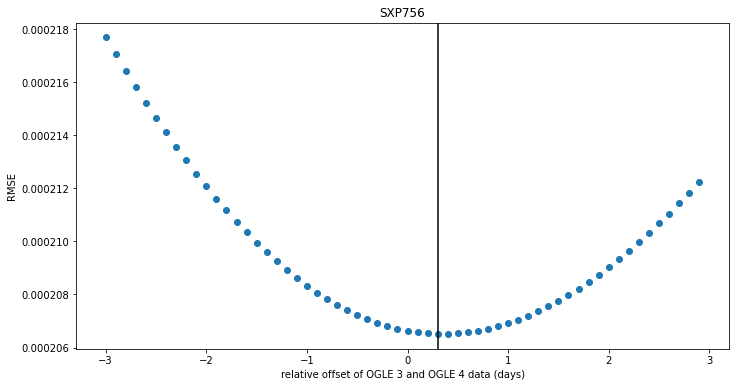

In [158]:
plt.scatter(np.array(results)[:,0],np.array(results)[:,1])
plt.axvline(np.array(results)[:,0][np.argmin(np.array(results)[:,1])], c="black")
plt.xlabel("relative offset of OGLE 3 and OGLE 4 data (days)")
plt.ylabel("RMSE")
plt.title(source["Object"])
plt.show()

In [160]:
np.array(results)[:,0][np.argmin(np.array(results)[:,1])]

0.30000000000000293

In [141]:
data_df.iloc[:627]

,ds,y
0,2001-06-26 10:17:33.503988736,0.004003
1,2001-07-16 10:06:04.896015872,0.003988
2,2001-07-23 08:11:30.048010624,0.004014
3,2001-07-24 08:32:01.248011264,0.003988
4,2001-07-25 10:04:03.072013568,0.004000
...,...,...
622,2009-01-25 03:00:34.559981568,0.003733
623,2009-01-31 01:45:32.256017664,0.003709
624,2009-02-06 01:31:38.495985664,0.003781
625,2009-04-27 10:06:29.952005376,0.003705
